In [109]:
import torch 
from torch import nn 
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torchvision.models import resnet50, resnet101, vgg16
import torch.optim as optim 
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from torchvision import datasets, transforms
from PIL import Image
import pandas as pd
import os 
from skimage import io, transform 
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np 
from torchvision import transforms, utils
from torchvision import models
from torch.nn import functional as F
from skimage.transform import resize
import json
import csv 
from matplotlib import pyplot as plt 
import random 
from math import pi 
import torch.nn.functional as F

In [110]:
def show_images(image):
    plt.imshow(image)



In [111]:
# Get all images for data that is used in the random forest 
def image(image_path):

        image = io.imread(image_path)
        image = image.transpose((2, 0, 1)) # Go from H, W, C to C, H, W which the network expects

        # image = Image.open(image_path)

        # label = np.array(label, dtype=float).reshape(-1, 5)
        
        
        # Convert image and label to tensors 
        image = torch.from_numpy(image).float()
        original_w, original_h = image.shape[1], image.shape[2]
        aspect_ratio = original_w / original_h
        target_size = (224, 224)
        if target_size[0] / target_size[1] > aspect_ratio:
            # Width is larger than the desired aspect ratio
            padded_width = target_size[0]
            padded_height = int(padded_width / aspect_ratio)
        else:
            # Height is larger than the desired aspect ratio
            padded_height = target_size[1]
            padded_width = int(padded_height * aspect_ratio)

        h_padding = (padded_width - original_w) // 2
        v_padding = (padded_height - original_h) // 2
        padding = (h_padding, v_padding, h_padding, v_padding)
        padded_img_tensor = transforms.Pad(padding, padding_mode='reflect')(image)
        image = transforms.Resize(target_size, antialias=True)(padded_img_tensor)

        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
        image = image.unsqueeze(0)

        return image


# 1424 images train
# 357 images validate


In [112]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, data_path, transform=None):
        super().__init__()
        self.data_path = data_path
        self.transform = transform
        self.labels = pd.read_csv(csv_file) 

    
    def __len__(self): 
        return len(self.labels)
    
    def __getitem__(self, index): 
        # Uncomment to get data for the randomforest 
        # location = "./Data_tree_full.csv"
        # tree = pd.read_csv(location)
        # with open("data_new.json", 'r') as f: 
        #     data = json.load(f)
        # tree["time"][index]
        # for x in tree["time"]:
        #     if x in data: 
        #         if data[x]["picture"] != None:
        #             image_path = os.path.join("./weather_used/", data[x]["picture"])
        # image_path = os.path.join(self.data_path, self.labels.iloc[index, 5])
        image_path = os.path.join(self.data_path, self.labels.iloc[index, 4])
        image = io.imread(image_path)
        # new_width = int(image.shape[1] * 0.39) # 228
        # new_height = int(image.shape[0] * 0.39) # 184
        new_width = 224
        new_height = 224

        # print(f"New width: {new_width}")
        # print(f"New height: {new_height}")
        # image = resize(image, (new_height, new_width), anti_aliasing=True)

        # upsample = nn.Upsample(size=(928, 928), mode="bilinear")

        # Resize the image to 224 x 224 
        image = transform.resize(image, (224, 224))
        # image = transform.resize(image, (928, 928))
 

        # image = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(image)

        image = image.transpose((2, 0, 1)) # Go from H, W, C to C, H, W which the network expects

        # image = Image.open(image_path)

        if self.transform: 
            image = self.transform(image)
        
        # label = self.labels.iloc[index, 0:5] # With no rain label 
        label = self.labels.iloc[index, 0:4] # Removed no rain label
        # label = np.array(label, dtype=float).reshape(-1, 5)
        
        
        # Convert image and label to tensors 
        image = torch.from_numpy(image).float()
        # image = upsample(image)


        label = torch.tensor(label).float()
        # image = self.random_rotation(image)
        # image = transforms.Normalize(mean=[0.0081, 0.0132, 0.0119], std=[0.0081, 0.0132, 0.0119])(image)
        
        # label = F.one_hot(label, num_classes=5)
        # print(f"Label: {label}")

        return image, label

    def random_rotation(self, image):
        angle = random.uniform(0, 360)
        trans = transforms.RandomRotation(degrees=angle)
        rotated_image = trans(image)
        


        return rotated_image


In [113]:
# Rain net maybe


In [114]:
# Test model from HW3 not as good as resnet but something that we tried 
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # According to the PyTorch Documentation:
        # "if a nn.Conv2d layer is directly followed by a nn.BatchNorm2d layer, then the bias 
        # in the convolution is not needed. The first step of BatchNorm subtracts the mean, which
        # effectively cancels out the bias effect"
        # "This applies to 1d and 3d convolutions as long as BatchNorm (or other normalization layer)
        # normalizes on the same dimension as convolution's bias"
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=(3, 3), padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.LazyLinear(out_features=256)
        self.fc2 = nn.LazyLinear(out_features=128)
        self.fc3 = nn.LazyLinear(out_features=4)
        self.flat = nn.Flatten()



    def forward(self, x): 
        x = self.pool(self.bn1(torch.relu(self.conv1(x)))) 
        x = self.pool(self.bn2(torch.relu(self.conv2(x)))) 
        x = self.pool(self.bn3(torch.relu(self.conv3(x)))) 
        
        x = self.pool(self.bn4(torch.relu(self.conv4(x))))
        x = self.flat(x)
        x = torch.relu(self.fc1(x)) 
        x = torch.relu(self.fc2(x)) 
        x = self.fc3(x) 
        return x

# model = Net()
model = resnet50(weights=None)
# model = resnet50()
# model = resnet101(weights=None)

# model = vgg16(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes)
# in_features = model.classifier[-1].in_features
# model.classifier[-1] = nn.Linear(in_features, 4)



In [115]:
# Get all the data 
# Used to test the entire model and to get the data for the random forest 
def getAllData():
    mean_sum = 0.0
    std_sum = 0.0
    total_samples = 0

    data = MyDataset("./NewData.csv", "./weather_new/", transform=None)
    # Train on 80% of the dataset
    train_size = int(0.8 * len(data)) 

    # Validate on the remaining 20% of the dataset
    val_size = len(data) - train_size

    data_full = DataLoader(dataset=data, batch_size=1, shuffle=False, num_workers=4)
        
    return data_full

In [116]:
# Get training and validation data (used for training and testing)
def getData():
    mean_sum = 0.0
    std_sum = 0.0
    total_samples = 0

    # composed = transforms.Compose([
    # ])
    data = MyDataset("./NewData_4.csv", "./weather_new/", transform=None)
    # Train on 80% of the dataset
    train_size = int(0.8 * len(data)) 

    # Validate on the remaining 20% of the dataset
    val_size = len(data) - train_size

    # Randomly split the dataset into training and testing data

    # all_data = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, num_workers=4)


    # for  batch, (images, labels) in enumerate(all_data):
    #     print(f"Image shape: ", images.shape) #[32, 3, 244, 244]

    #     mean_sum += torch.mean(images, dim=(0, 2, 3)) # 0, 2, 3
    #     std_sum += torch.mean(images, dim=(0, 2, 3))
    #     total_samples += images.size(0)



    # overall_mean = mean_sum / total_samples
    # overall_std = std_sum / total_samples

    # print(f"Calculated Mean: ", overall_mean)
    # print(f"Calculated Standard Deviation: ", overall_std)
        
        
    
    train_dataset, val_dataset = random_split(data, [train_size, val_size])
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader 

In [117]:
# test the model 
def test(): 
    model.eval()
    n_correct = 0 
    n_incorrect = 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in val_loader: 
            # print(f"Shape: {images.shape}")
            images, labels = images.to(device), labels.to(device)

            
            # Forward Pass
            output = model(images)
            
            test_loss += lossFunc_test(output, labels).item()


            output.data = torch.sigmoid(output) # Convert output data to between 0 and 1
            # output = output.to('cpu')
            # print(f"Predictions: {np.round(output.numpy(), decimals=3)}")

            # predictions = (output > 0.9).int()
            predictions = (output > 0.5).int()
            
            # print(f"Predictions: {predictions}")
            # print(f"True labels: {labels}")

            n_correct += (predictions == labels).all(dim=1).sum()
            n_incorrect += (predictions != labels).all(dim=1).sum()
             


    # output.data = torch.mul(100, output) # conver the data / confidence into %
    test_loss /= len(val_loader.dataset)
    print("\nTest set: Avg. loss: {:.4f} Accuracy: {}/{} ({:.2f}%)\n".format(
        test_loss, n_correct, len(val_loader.dataset), 
        100. * (n_correct / len(val_loader.dataset))))
    
    accuracy = (100. * (n_correct / len(val_loader.dataset)))
    accuracy = accuracy.to("cpu")
    # print(f"Accuracy: {accuracy}")

    return accuracy

In [118]:
# Test the model for the tree (generate the data that goes into the tree)
def testTree():  
    model = torch.load("model_FULL_28.pth")
    model.to(device)
    model.eval()
    location = "./Data_tree_full.csv"
    tree = pd.read_csv(location)
    with open("data_new.json", 'r') as f: 
        data = json.load(f)
    
    count = 0
    row = []
    # predictions = open("Predict", "w")
    for i, x in enumerate(tree["time"]): 
        if x in data: 

            # print(data[x]["picture"])
            if data[x]["picture"] != None:
                loc = os.path.join("./weather_used/", data[x]["picture"])
                count += 1 
                img = image(loc)
                # print(img)
                img = img.to(device)
                output = model(img)

                output.data = torch.sigmoid(output) # Convert output data to between 0 and 1
                out = output.cpu()
                prediction = np.round(out.detach().numpy(),decimals=3)[0]
                # print(prediction)
                # predictions.write(str(prediction.tolist()) + "\n")
                # predictions.write(str(prediction.tolist()))
                # predictions.write("\n")
                # print(f"Predictions: {prediction}")
                # cpu = output.to('cpu')
                # row.append(out)

            else: 
                print(tree["precipitation"][i])
                s = pd.Series(tree["precipitation"][i])
                # predictions.write(str(s.tolist()[0]) + "\n")
                # row.append(tree["precipitation"][i])

    # tree.insert((len(tree.columns), "cnn"), row)
    # predictions.close()
    print(row)


In [119]:
# Main training function 
def train(running_loss, epoch):
    model.train()
    for batch, (images, labels) in enumerate(train_loader): 
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad() 
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()

            if batch % log_interval == 0: 
                print('Epoch [{}/{}], Step [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, num_epochs, (batch * len(images)), len(train_loader.dataset),
                100. * (batch / len(train_loader)), loss.item()))

                # Save model and optimizer to continue training if necessary
                torch.save(model.state_dict(), './model.pth')
                torch.save(optimizer.state_dict(), './optimizer.pth')

    # scheduler.step(running_loss)
    return running_loss
    

Using device: cuda:0
Initial Test: 



Test set: Avg. loss: 20.0469 Accuracy: 30/863 (3.48%)

Epoch [1/500], Step [0/3451 (0%)]	Loss: 0.710945
Epoch [1/500], Step [1024/3451 (30%)]	Loss: 0.675502
Epoch [1/500], Step [2048/3451 (59%)]	Loss: 0.570789
Epoch [1/500], Step [3072/3451 (89%)]	Loss: 0.521292
Epoch [1/500], Average Loss: 0.5796

Test set: Avg. loss: 2.5169 Accuracy: 283/863 (32.79%)

Epoch [2/500], Step [0/3451 (0%)]	Loss: 0.463964
Epoch [2/500], Step [1024/3451 (30%)]	Loss: 0.441663
Epoch [2/500], Step [2048/3451 (59%)]	Loss: 0.590002
Epoch [2/500], Step [3072/3451 (89%)]	Loss: 0.549431
Epoch [2/500], Average Loss: 0.5220
Epoch [3/500], Step [0/3451 (0%)]	Loss: 0.418037
Epoch [3/500], Step [1024/3451 (30%)]	Loss: 0.562911
Epoch [3/500], Step [2048/3451 (59%)]	Loss: 0.449747
Epoch [3/500], Step [3072/3451 (89%)]	Loss: 0.465348
Epoch [3/500], Average Loss: 0.5114
Epoch [4/500], Step [0/3451 (0%)]	Loss: 0.528341
Epoch [4/500], Step [1024/3451 (30%)]	Loss: 0.426639
Epoch [4/500], Step [2048/3451 (59%)]	Loss: 0.505843


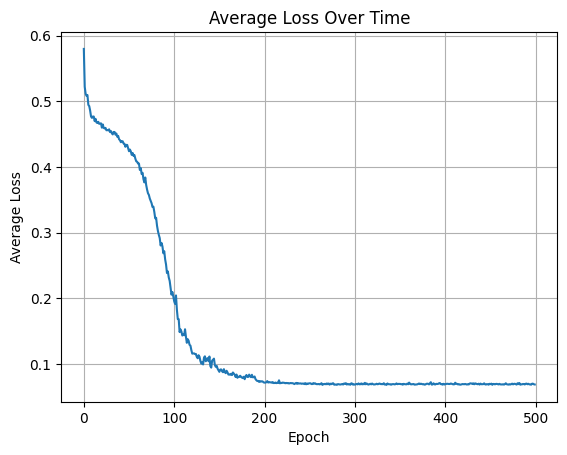

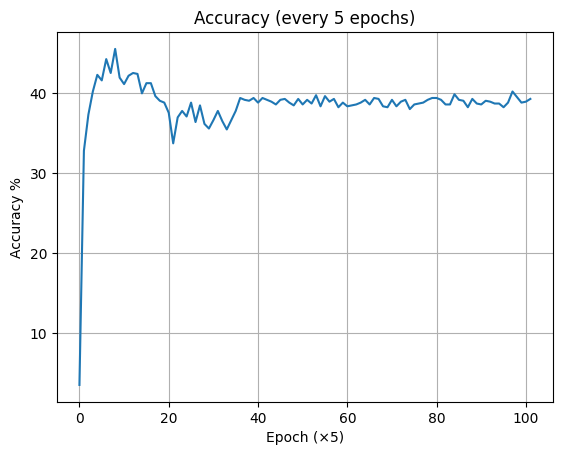

In [120]:
if __name__ == '__main__':
    num_epochs = 500 
    batch_size = 32
    learning_rate = 0.001
    log_interval = 32
    num_classes = 4
    loss_list = []
    accuracy_list = []

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # device = 'cpu'
    print(f"Using device: {device}")
    
    
    train_loader, val_loader = getData()
    # data = getData()
    # data

    model.to(device)
     
    
    # criterion = nn.MultiLabelSoftMarginLoss()
    # lossFunc_test = nn.MultiLabelSoftMarginLoss(reduction="sum")
    # criterion = nn.BCELoss()
    # lossFunc_test = nn.BCELoss(reduction="sum")

    criterion = nn.BCEWithLogitsLoss()
    lossFunc_test = nn.BCEWithLogitsLoss(reduction="sum")

    
    
    # Try again 400 epochs
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                    max_lr = 0.01, 
                                                    steps_per_epoch=len(train_loader),
                                                    epochs=num_epochs
                                                    )
    # scheduler = ReduceLROnPlateau(
    #     optimizer, 
    #     mode='min',  
    #     factor=0.1, 
    #     patience=10,
    #     threshold=0.0001, 
    #     cooldown=0, 
    #     min_lr = 1e-6, 
    #     verbose=True
    # )                   
    
    print("Initial Test: ")
    accuracy = test()
    accuracy_list.append(accuracy)
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_loss += train(running_loss, epoch)

        average_loss = running_loss / len(train_loader)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {average_loss:.4f}")

        # Test every 5 epochs 
        if epoch % 5 == 0:
            accuracy = test()
            accuracy_list.append(accuracy)

        loss_list.append(average_loss)


    # Final test
    accuracy = test()
    accuracy_list.append(accuracy)

    print("Training Finished")
    torch.save(model, "./model_FULL.pth")

    epoch_range = range(0, num_epochs)
    plt.plot(epoch_range, loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("Average Loss Over Time")
    plt.grid(True)
    plt.show()

    
    epoch_range_test = range(0, len(accuracy_list))
    plt.plot(epoch_range_test, accuracy_list)
    plt.xlabel("Epoch (×5)")
    plt.ylabel("Accuracy %")
    plt.title("Accuracy (every 5 epochs)")
    plt.grid(True)

    plt.show()

    


